This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path\
To run this code, you need to install shapely, geopandas matplotlib and numpy 

In [2]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString,MultiLineString, MultiPoint
import shapely
import geopandas as gpd
import numpy as np
import pandas as pd
import math
from dubins_curves import *

## Garbage experiments


In [2]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_2.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [3]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_2.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

In [4]:
coordinates[0][0]

[[358.37, 546.33],
 [595.18, 502.9],
 [600, 240],
 [529.97, 22.56],
 [513.55, 18.56],
 [294.72, 51.94],
 [281.7, 62.66],
 [358.37, 546.33]]

<Axes: >

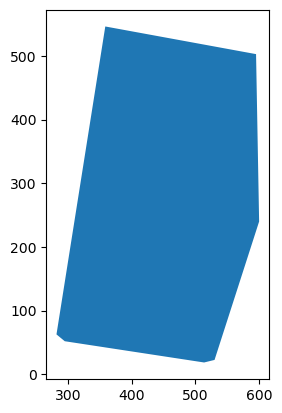

In [5]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
# hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
# obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-10)
# hole.plot()
polygon1.plot()

In [6]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

# Uncomment these lines if you want to have a hole in your field
# field = polygon1.symmetric_difference(hole) 
# field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)


field = polygon1
field_with_headlands = polygon1_buffer

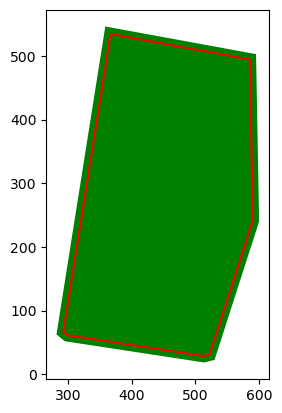

In [7]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [8]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,358.37,546.33
0,595.18,502.90
0,600.00,240.00
0,529.97,22.56
0,513.55,18.56
0,294.72,51.94
0,281.70,62.66
0,358.37,546.33


C:\Users\hidde\AppData\Local\Temp\ipykernel_26976\1918966130.py:15: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  swath_clipped.plot(ax = ax, color = 'magenta')


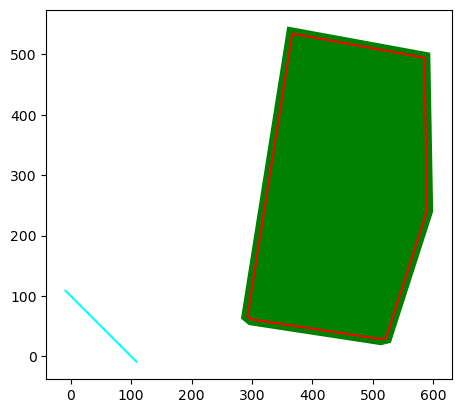

In [9]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

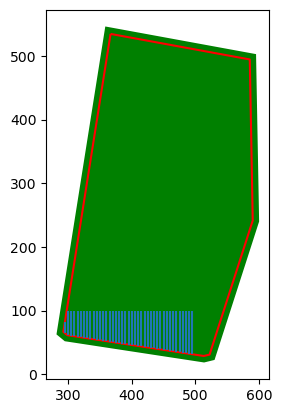

2162.9168561483148


In [10]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)

In [11]:
# import numpy as np

def rotate_vector_z(vector, theta_z):
    # Convert angle to radians
    theta_z = np.radians(theta_z)

    # 2D Rotation matrix around the z-axis
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z)],
                    [np.sin(theta_z), np.cos(theta_z)]])

    # Rotate the vector
    rotated_vector = np.dot(R_z, vector)

    return rotated_vector

# Example usage
vector = np.array([1, 0])  # Example vector along the x-axis
theta_z = 45  # Rotation angle in degrees around z-axis

rotated_vector = rotate_vector_z(vector, theta_z)
print("Original Vector:", vector)
print("Rotated Vector around Z-axis:",rotated_vector)

Original Vector: [1 0]
Rotated Vector around Z-axis: [0.70710678 0.70710678]


In [12]:
# Example usage
vector = np.array([10000, 0])  # Example vector along the x-axis
for theta_z in range(0,95,5):
    # theta_z = 45  # Rotation angle in degrees around z-axis
    d = 10
    dx = d/(np.sin(np.radians(theta_z))+0.01)
    rotated_vector = rotate_vector_z(vector, theta_z)
    rotated_vector = [[0,0],list(rotated_vector)]
    vector_list = []
    if theta_z == 0:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
    else:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



    swaths = []
    swaths_clipped = []
    for i in range(len(vector_list)):
        swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
        swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

    # fig, ax = plt.subplots()
    # field.plot(ax = ax, color = 'green')
    # field_with_headlands.boundary.plot(ax = ax,color = 'red')
    total_swath_length = 0
    for i in range(len(swaths_clipped)):
        if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
            # swaths_clipped[i].plot(ax = ax)
            total_swath_length+=swaths_clipped[i][0].length

    # plt.show()
    
    print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))



Theta: 0.000000, total_length: 1207.206956
Theta: 5.000000, total_length: 2374.810652
Theta: 10.000000, total_length: 3513.005561
Theta: 15.000000, total_length: 4697.471350
Theta: 20.000000, total_length: 5548.866010
Theta: 25.000000, total_length: 6092.962235
Theta: 30.000000, total_length: 6390.934012
Theta: 35.000000, total_length: 6462.943006
Theta: 40.000000, total_length: 5917.550939
Theta: 45.000000, total_length: 4633.915940
Theta: 50.000000, total_length: 2772.733779
Theta: 55.000000, total_length: 1274.095000
Theta: 60.000000, total_length: 283.731502
Theta: 65.000000, total_length: 0.000000
Theta: 70.000000, total_length: 0.000000
Theta: 75.000000, total_length: 0.000000
Theta: 80.000000, total_length: 0.000000
Theta: 85.000000, total_length: 0.000000
Theta: 90.000000, total_length: 0.000000


Theta: 5.000000, total_length: 2374.810652


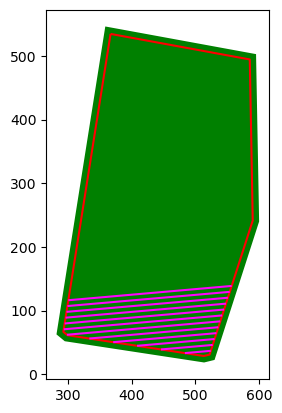

In [13]:
d = 10
theta_z = 5  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([10000, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
else:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax,color = 'magenta')
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

plt.show()

1878.6717201392585

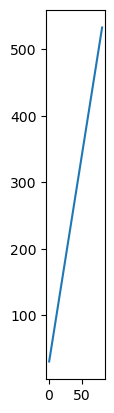

In [14]:
def linefromvec(vec):
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

vector = np.array([[308.976881,	75.054454],[379.051873,	517.120079]])
slope,intercept = linefromvec(vector)
# xmin = min(field1_with_headlands.get_coordinates()['x'])
# xmax = max(field1_with_headlands.get_coordinates()['x'])
# ymin = slope*xmin+intercept
# ymax = slope*xmax+intercept

ymin = min(field_with_headlands.get_coordinates()['y'])
ymax = max(field_with_headlands.get_coordinates()['y'])
xmin = ymin/slope-intercept
xmax = ymax/slope-intercept

# plt.plot(vector[0],vector[1])
vector = np.array([[xmin-xmin,ymin],[xmax-xmin,ymax]])

line = gpd.GeoSeries(LineString(vector))
fig, ax = plt.subplots()
line.plot(ax = ax)

xmin

Theta: 0.000000, total_length: 9638.888311


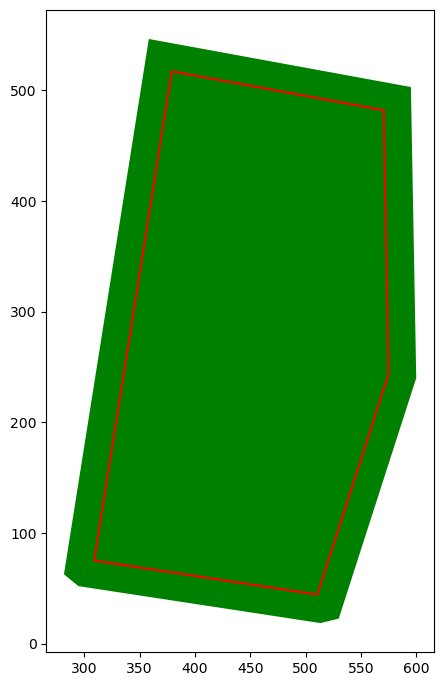

array([[  0.        ,  28.74373804],
       [ 80.19420004, 534.64603146]])

In [15]:
field1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
field1_with_headlands = field1.buffer(-25)
fig, ax = plt.subplots(figsize = [5,10])
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')


d = 10
theta_z = 00  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
dx = 10
# dx = d
# vector = np.array([[xmin,ymin],[xmax,ymax]])
# rotated_vector = rotate_vector_z(vector, theta_z)
# rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-100,100):
        vector_list.append([[vector[0][0]+i*d,vector[0][1]],[vector[1][0]+i*d,vector[1][1]]])
else:
    for i in range(-100,100):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])

swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field1_with_headlands))

total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        # swaths_clipped[i].plot(ax = ax,color = 'magenta')
        # swaths[i].plot
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

fig.savefig('./data/images/field_with_headlangs.svg', format='svg')
plt.show()

# swaths_clipped[15].get_coordinates()
vector

In [16]:

swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
list_coords = []
for i in range(len(swaths_clipped_nonempty)):
    list_coords.append(swaths_clipped_nonempty[0].get_coordinates())


In [17]:
field1_with_headlands.get_coordinates()

,x,y
0,308.976881,75.054454
0,379.051873,517.120079
0,570.559007,481.998442
0,574.927914,243.702689
0,510.701844,44.283631
0,308.976881,75.054454


In [18]:
np.array([379.051873,	517.120079])-np.array([308.976881,	75.054454])
# swaths_clipped_nonempty

array([ 70.074992, 442.065625])

In [19]:
from dubins_curves import *

line1 = swaths_clipped_nonempty[0]
line2 = swaths_clipped_nonempty[1]
line1_coords = line1.get_coordinates()
line2_coords = line2.get_coordinates()
point1 = line1_coords.iloc[1]
point2 = line2_coords.iloc[1]



diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
slope1 = diff1['y']/diff1['x']
heading_1 = math.degrees(math.atan(slope1))

diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
slope2 = diff2['y']/diff1['x']
heading_2 = math.degrees(math.atan(slope2))+180

pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)
turning_rad = 5

path = dubins_main(pt1,pt2,turning_rad)




In [20]:
# LineString(path)
curve1 = LineString(path[:,0:2])

<Axes: >

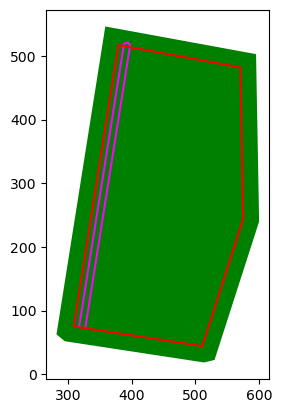

In [21]:
# MultiLineString((line1,curve1,line2))
line = gpd.GeoSeries((line1[0],curve1,line2[0]))
fig, ax = plt.subplots()
line.plot(ax = ax, color = 'magenta')
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
# line1[0]

In [22]:

turning_rad = 10
line = []

for i in range(len(swaths_clipped_nonempty)-1):
    line1 = swaths_clipped_nonempty[i]
    line2 = swaths_clipped_nonempty[i+1]
    line1_coords = line1.get_coordinates()
    line2_coords = line2.get_coordinates()

    if i%2 != 0:
        point1 = line1_coords.iloc[0]
        point2 = line2_coords.iloc[0]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))+180

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))
        pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2)
    else:
        point1 = line1_coords.iloc[1]
        point2 = line2_coords.iloc[1]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))+180
        pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)



    path = dubins_main(pt1,pt2,turning_rad)
    curve1 = LineString(path[:,0:2])
    line.append(gpd.GeoSeries((line1[0],curve1,line2[0])))
        


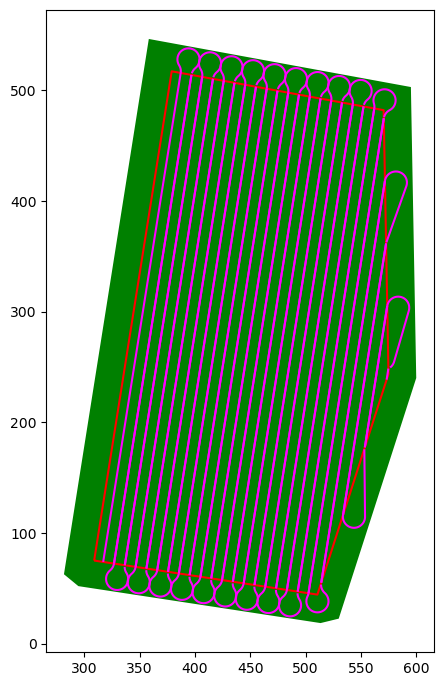

In [23]:

fig, ax = plt.subplots(figsize = [5,10])

field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
for i in range(len(line)):
    line[i].plot(ax = ax, color = 'magenta')

fig.savefig('./data/images/field_generated_swaths.svg', format='svg')


In [25]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


180-np.degrees(angle_between([236.81, -43.43],[1, 0]))

169.60767002751743

In [106]:
# def edge_angles(coords):
#     horizontal_line = [1,0]
#     angles = []
#     for i in range(len(coords)-1):
#         line1 = np.array([[coords.iloc[i]['x'],coords.iloc[i]['y']],[coords.iloc[i+1]['x'],coords.iloc[i+1]['y']]])
#         line1_origin = line1[1]-line1[0]
#         angles.append(np.degrees(angle_between(line1_origin,horizontal_line)))
#     angles = pd.DataFrame(data = {'angles':angles})
#     return angles


# coords = field.get_coordinates()
# coords_angles = edge_angles(coords)
# coords_angles['difference'] = coords_angles['angles'].diff()
def edge_angles(coords):
    horizontal_line = [1,0]
    angles = []
    lines = []
    lines_origin = []
    for i in range(len(coords)-2):
        line1 = np.array([[coords.iloc[i]['x'],coords.iloc[i]['y']],[coords.iloc[i+1]['x'],coords.iloc[i+1]['y']]])
        line2 = np.array([[coords.iloc[i+1]['x'],coords.iloc[i+1]['y']],[coords.iloc[i+2]['x'],coords.iloc[i+2]['y']]])
        line1_origin = line1[1]-line1[0]
        line2_origin = line2[1]-line2[0]
        angles.append(np.degrees(angle_between(line1_origin,line2_origin)))
        lines.append(LineString(line1))
        lines_origin.append(line1_origin)
    angles = pd.DataFrame(data = {'angles':angles, 'lines':lines, 'lines_origin': lines_origin})

    return angles


coords = field.get_coordinates()
coords_angles = edge_angles(coords)
coords_angles['180-angle'] = 180-coords_angles['angles']
# coords_angles['dif
coords_angles['radians'] = np.radians(coords_angles['180-angle'])
coords_angles['arc_incl'] = 2*np.arcsin(1/np.tan(coords_angles['radians']/2))
coords_angles

,angles,lines,lines_origin,180-angle,radians,arc_incl
0,78.557329,"LINESTRING (358.37 546.33, 595.1799999999999 5...","[236.80999999999995, -43.430000000000064]",101.442671,1.770509,1.915395
1,18.902319,"LINESTRING (595.1799999999999 502.9, 600 240)","[4.82000000000005, -262.9]",161.097681,2.811685,0.334490
2,58.457128,"LINESTRING (600 240, 529.97 22.56)","[-70.02999999999997, -217.44]",121.542872,2.121323,1.187651
3,22.363851,"LINESTRING (529.97 22.56, 513.55 18.56)","[-16.420000000000073, -4.0]",157.636149,2.751270,0.397976
4,30.793332,"LINESTRING (513.55 18.56, 294.72 51.94)","[-218.82999999999993, 33.379999999999995]",149.206668,2.604148,0.557977
5,59.541129,"LINESTRING (294.72 51.94, 281.7 62.66)","[-13.020000000000039, 10.719999999999999]",120.458871,2.102404,1.217941


In [116]:
turning_rad = 100
s = turning_rad*1/np.tan(coords_angles['radians']/2)
s

0    81.786886
1    16.646643
2    55.953555
3    19.767753
4    27.538329
5    57.202335
Name: radians, dtype: float64

(346.0742291202164, 616.5811884754561, 224.6835, 561.6465000000001)

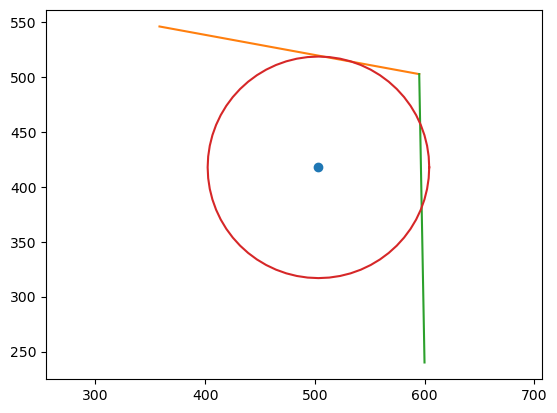

In [147]:
ab = coords_angles['lines_origin'].iloc[0]
normal_ab = unit_vector([ab[1],-ab[0]])

arc_end = ab + s[0]*normal_ab
circ_center = arc_end + turning_rad*-1*(normal_ab)-ab+[500,400]
from shapely import points
circ_center_point = points(circ_center)
circle_geom = circ_center_point.buffer(turning_rad+1)
circle_geom
linestring_plot = coords_angles['lines'].iloc[0]
linestring_plot2 = coords_angles['lines'].iloc[1]
plt.plot(*circ_center_point.xy, 'o')
plt.plot(*linestring_plot.xy)
plt.plot(*linestring_plot2.xy)
plt.plot(*circle_geom.boundary.xy)
plt.axis('equal')

In [230]:
# # shapely.unary_union([linestring_plot,linestring_plot2,circle_geom.boundary])
# line1 = shapely.intersection_all([linestring_plot,circle_geom.boundary])
# # line2 = shapely.intersection_all([linestring_plot2,circle_geom.boundary])
# # plt.plot(*line1.xy)
# # plt.plot(*line2.xy)
b = 20
# field.boundary.plot()
from shapely import MultiPoint
rounded = field.buffer(b).buffer(-2*b).buffer(b).boundary
rounded.length
distances = np.arange(0,int(np.ceil(rounded.length)),10)
interpolated = LineString([rounded[0].interpolate(distance) for distance in distances])
# type(rounded[0])
# interpolated_plt = LineString(interpolated)

C:\Users\hidde\AppData\Local\Temp\ipykernel_2224\3324263024.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  distances = np.arange(0,int(np.ceil(rounded.length)),10)


(267.5090437337383, 615.6590472562272, -6.988185951756336, 568.9634972586298)

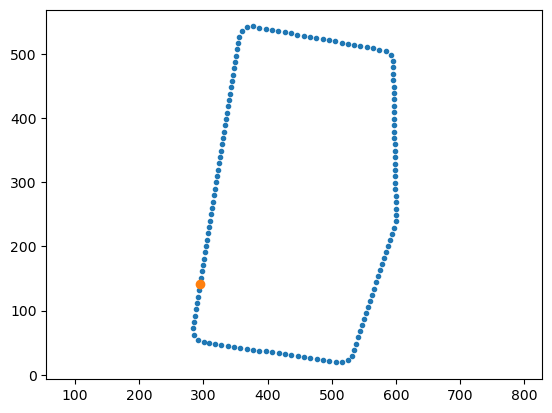

In [241]:
df = path_to_df([gpd.GeoSeries(interpolated)])
plt.plot(df['x'],df['y'], '.')
plt.plot(df['x'].iloc[10],df['y'].iloc[10], 'o')
plt.axis('equal')

In [400]:
from shapely import Point
from shapely.ops import split, nearest_points
def path_headlands(headland_size,tractor_width,turning_rad,field,interp_distance = 10):
    nr_passes_needed = headland_size//tractor_width
    paths_list = []
    for i in range(nr_passes_needed):
        path = field.buffer(-1*(tractor_width/2+i*tractor_width))
        path_rounded_edge = path.buffer(turning_rad).buffer(-2*turning_rad).buffer(turning_rad)
        distances = np.arange(0,int(path_rounded_edge.length),interp_distance)
        interpolated = LineString([path_rounded_edge[0].boundary.interpolate(distance) for distance in distances])
        paths_list.append(interpolated)
    return paths_list

def connect_headlands(headland_paths,best_path,turning_rad):
    result_list = []
    command_list = [[0]]
    for i in range(len(headland_paths)):
        
        if i == 0:
            end_point = Point([best_path['x'].iloc[-1], best_path['y'].iloc[-1]])
            diff_x = (best_path['x'].iloc[-2]-best_path['x'].iloc[-1])
            diff_y = (best_path['y'].iloc[-2]-best_path['y'].iloc[-1])
            slope = diff_y/diff_x
            heading1 = math.degrees(math.atan(slope))
            result_list.append(gpd.GeoSeries(end_point))
        else:
            diff = (result_list[-1].get_coordinates().iloc[-1]-result_list[-1].get_coordinates().iloc[-2])
            diff_x = diff.x
            diff_y = diff.y
            slope = diff_y/diff_x
            heading1 =  90- math.degrees(math.atan(slope))
            # heading1 = 180

            end_point = Point(result_list[-1].get_coordinates().iloc[-1])
        _,closest_point  = nearest_points(end_point,headland_paths[-1-i])
        

        
        result = split(headland_paths[-1-i],closest_point.buffer(0.1))
        print(result)

        pt1 = (end_point.x,end_point.y,heading1)
        pt2 = (result.geoms[1].coords[0][0],result.geoms[1].coords[0][1],180)

        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        result_list.append(gpd.GeoSeries(curve1))
        command_list.append([0]*len(curve1.coords))
        result_list.append(gpd.GeoSeries(result.geoms[1]))
        result_list.append(gpd.GeoSeries(result.geoms[2]))
        result_list.append(gpd.GeoSeries(result.geoms[0]))
        command_list.append([1]*(len(result.geoms[1].coords)+len(result.geoms[2].coords)+len(result.geoms[0].coords)))
        # print(len(command_list))
    command_list = [val for sublist in command_list for val in sublist]
    len_list = [len(result.get_coordinates()) for result in result_list]
    # print(sum(len_list))
    # print(len_list)
    print(len(command_list))
    df = path_to_df(result_list,command_list)
    return df
turning_rad = 20
paths = path_headlands(10,5,turning_rad,field)
headland_path = connect_headlands(paths,best_path,turning_rad)


GEOMETRYCOLLECTION (LINESTRING (308.823863863749 57.37537099519001, 299.7152663146242 61.24938271789108, 293.5815494557741 69.01420316728743, 291.922646617594 78.7668475096568, 293.414048613939 88.65342619459206, 294.979672106846 98.53010696691925, 296.5452955997529 108.4067877392465, 298.1109190926599 118.2834685115736, 299.6765425855669 128.1601492839008, 301.2421660784739 138.036830056228, 302.8077895713809 147.9135108285552, 304.3734130642879 157.7901916008824, 305.9390365571949 167.6668723732096, 307.5046600501019 177.5435531455368, 309.0702835430089 187.420233917864, 310.6359070359159 197.2969146901912, 312.2015305288228 207.1735954625184, 313.7671540217299 217.0502762348456, 315.3327775146369 226.9269570071728, 316.8984010075438 236.8036377795, 318.4640245004508 246.6803185518272, 320.0296479933579 256.5569993241544, 321.5952714862648 266.4336800964816, 323.1608949791718 276.3103608688087, 324.7265184720788 286.1870416411359, 326.2921419649858 296.0637224134632, 327.857765457892

C:\Users\hidde\AppData\Local\Temp\ipykernel_23984\1165919992.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  distances = np.arange(0,int(path_rounded_edge.length),interp_distance)


In [399]:
best_path

,x,y,command
0,344.479854,89.870226,1
1,345.262666,94.808566,1
2,346.045477,99.746907,1
3,346.828289,104.685247,1
4,347.611101,109.623587,1
...,...,...,...
1165,548.077482,236.080888,1
1166,547.294670,231.142547,1
1167,546.511858,226.204207,1
1168,545.729046,221.265867,1


(200.0, 350.0)

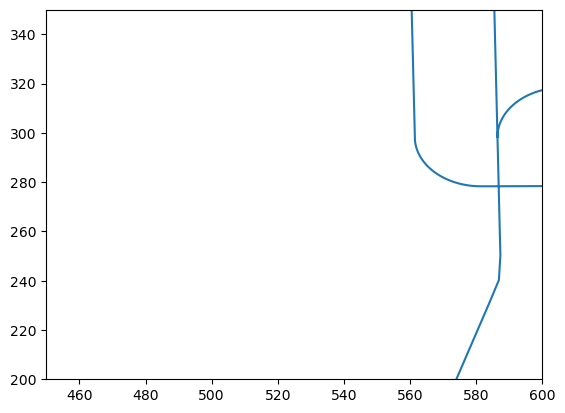

In [131]:
# from shapely.ops import split
# result = split(paths[-1],closest.buffer(0.001))
# result.geoms[1]
# result_list = [gpd.GeoSeries(result.geoms[1]),gpd.GeoSeries(result.geoms[2]),gpd.GeoSeries(result.geoms[0])]
# df = path_to_df(result_list)
n1 = 150
n = 1000
plt.plot(headland_path['x'].iloc[n1:n],headland_path['y'].iloc[n1:n])
plt.xlim([450,600])
plt.ylim([200,350])

# plt.axis('equal')
# len(paths)


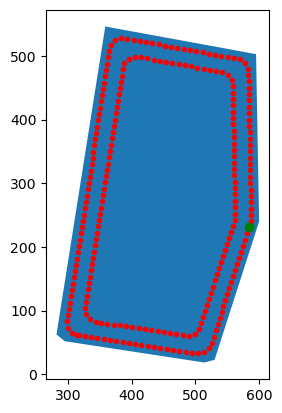

In [438]:
fig, ax = plt.subplots()
field.plot(ax = ax)
for i in range(len(paths)):
    ax.plot(*paths[i].xy, 'ro',markersize = 3)
# ax.plot(closest.x,closest.y, 'go')
ax.plot(584.013435121185,231.1514723351998, 'go')

<class 'shapely.geometry.linestring.LineString'>


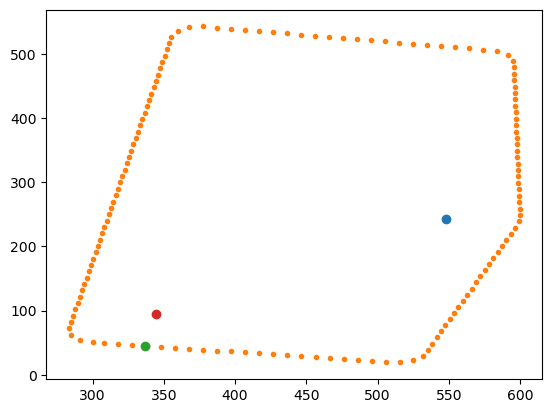

In [328]:
# end = Point(best_path.iloc[-1].item)
from shapely import Point
from shapely.ops import nearest_points

end = Point([best_path['x'].iloc[0],best_path['y'].iloc[0]])
print(type(interpolated))
p1,p2 = nearest_points(interpolated,end)
plt.plot(best_path['x'].iloc[-1],best_path['y'].iloc[-1], 'o')
plt.plot(df['x'],df['y'], '.')
plt.plot(*p1.xy,'o')
plt.plot(*p2.xy,'o')

In [96]:
import shapely
i = 0
line1 = LineString(np.array([[coords.iloc[i]['x'],coords.iloc[i]['y']],[coords.iloc[i+1]['x'],coords.iloc[i+1]['y']]]))
line2 = LineString(np.array([[coords.iloc[i+1]['x'],coords.iloc[i+1]['y']],[coords.iloc[i+2]['x'],coords.iloc[i+2]['y']]]))
shapely.intersection_all([line1,circle_geom])

(265.78499999999997, 615.915, -7.828500000000009, 572.7185000000001)

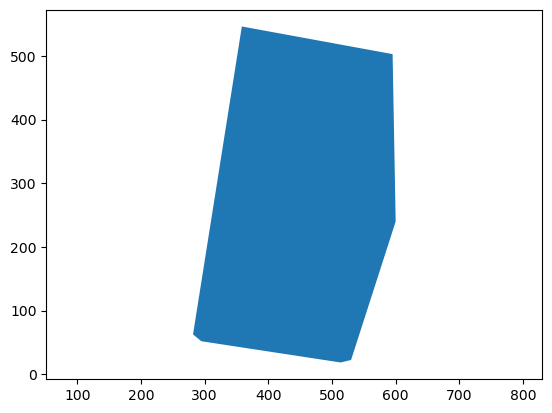

In [32]:
fig,ax = plt.subplots()
field.plot(ax = ax)
ax.axis('equal')

169.60767002751743

In [180]:
angle_between((1, 0, 0), (-1, 0, 0)) == angle_between((-1, 0, 0), (1, 0, 0))



True

## Best implementation

In [3]:
import pandas as pd

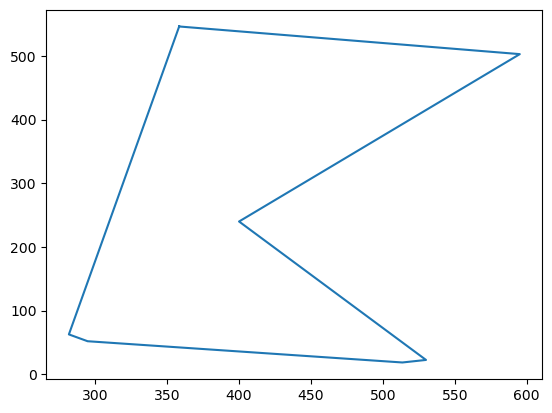

In [371]:
def load_data(filepath,include_obstacles = False):
    """
    function to load json file and create polygon object

    args:
        filepath (str): filepath that contains the json file to be parsed
        include_obstacles (bool): boolean to indicate if you want to include the obstacles in the resulting field (will probably be usefull for some debugging)

    returns:
        field (geopandas Geoseries)

    """
    # This cell opens the json file that contains field geometry
    with open(filepath) as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # This cell parses the json data and obtains a list with the coordinates for each polygon like
    # [[polygon1_coords],[polygon2_coords],....]
    # where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    polygons = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
        polygons.append(gpd.GeoSeries(Polygon(coordinates[i][0])))
    
    field = polygons[0]
    if include_obstacles:
        for i in range(1,len(polygons)):
            field = field.symmetric_difference(polygons[i])

    return field

field = load_data("./data/field_geometry/test_2.json")
# field.plot()
# field = field.buffer(-10)
field_coords = field.get_coordinates()

plt.plot(field_coords['x'],field_coords['y'])
# plt.xlim([380,450])
# plt.ylim([200,350])

In [372]:
angles = get_internal_angles(field.get_coordinates())
angles

[88.6150886662417,
 63.801710030123665,
 247.45856746664634,
 72.82294669029923,
 157.63614857989276,
 149.20666781426496,
 120.45887075253133]

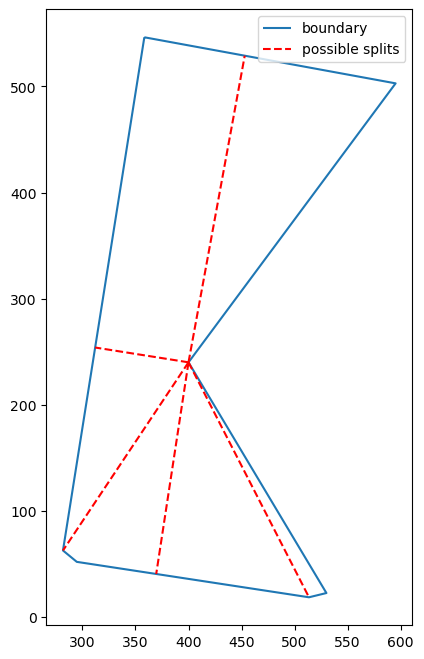

In [ ]:
def splitfields(field,field_coordinates, angles):
    '''splitting the fields, needs to return a list of geoseries objects'''
    # Small statement to check if we need to split the field at all
    if all(angle < 180 for angle in angles):
        print('Field is convex: no splits needed')
        return field

    # Creating a list of the indices of the corners that are non-convex (i.e. internal angle> 180)
    list_nonconvex_corners_indices = [index for index,angle in enumerate(angles) if angle >180]
    # Making a list of the actual points corresponding to the indices found above
    point_list_nonconvex_corners = [Point([row['x'],row['y']]) for index,row in field_coordinates.iterrows() if index in list_nonconvex_corners_indices]
    # Convert the polygon to a list of its edges
    exploded_edges = list(map(LineString, zip(field[0].boundary.coords[:-1], field[0].boundary.coords[1:])))
    
    normal_lines = []
    for point in point_list_nonconvex_corners:
        # First, create some lines that we can use to split the geometry, the lines go through the nonconvex corner and
        # are normal to some other edge (it tries it for lines normal to all edges, see the plot)
        points = [nearest_points(edge, point)[0] for edge in exploded_edges]
        normal_lines = [LineString([point,point2]) for point2 in points]
        # Now make a split according to all these lines
        splits = []
        for normal_line in normal_lines:
            splits.append(shapely.ops.split(field[0],normal_line))
        # Check if the resulting split geometries have internal angles < 180 degrees, if so it is valid and we store it
        valid_split = []
        for split in splits:
            angles = get_internal_angles(gpd.GeoSeries(split.geoms[0]).get_coordinates())
            
            if len(split.geoms) > 1:
                angles2 = get_internal_angles(gpd.GeoSeries(split.geoms[1]).get_coordinates())
                angles = angles+angles2    
            valid_split.append(all(angle < 180 for angle in angles)) 
        valid_split_geometries = [split for boolean, split in zip(valid_split, splits) if boolean]

    fig, ax = plt.subplots(figsize = (10,8))
    field.boundary.plot(ax = ax)
    for line in normal_lines:
        ax.plot(*line.xy, 'r--')
    ax.legend(['boundary', 'possible splits'],loc = 'upper right')
    


    return valid_split_geometries

field_coords = field.get_coordinates()
field_coords.reset_index(inplace = True)
valid_splits = splitfields(field,field_coords,angles)
# valid_splits

In [ ]:
angles

[88.6150886662417,
 101.44267124509697,
 161.09768138213605,
 121.54287155983624,
 157.63614857989276,
 149.20666781426496,
 120.45887075253133]

In [6]:
def get_internal_angles(coords):
    '''
    calculates the internal angles of the field and returns them in a df together with the field coords

    '''
    coords['dx'] = coords['x'].diff()
    coords['dy'] = coords['y'].diff()
    coords = coords.dropna()
    angles = []
    angles.append(np.pi + np.arctan2(coords['dx'].iloc[-1]*coords['dy'].iloc[0]-coords['dx'].iloc[0]*coords['dy'].iloc[-1],coords['dx'].iloc[-1]*coords['dx'].iloc[0]+coords['dy'].iloc[-1]*coords['dy'].iloc[0]))
    for i in range(1,len(coords)):
        angles.append(np.pi + np.arctan2(coords['dx'].iloc[i-1]*coords['dy'].iloc[i]-coords['dx'].iloc[i]*coords['dy'].iloc[i-1],coords['dx'].iloc[i-1]*coords['dx'].iloc[i]+coords['dy'].iloc[i-1]*coords['dy'].iloc[i]))
    angles_degrees = [np.degrees(angle) for angle in angles]
    return angles_degrees



In [602]:

import shapely.affinity


def generate_headlands(field,size):
    field_with_headlands = field.buffer(-size)
    return field_with_headlands
        

def linefromvec(vec):
    """
    turn a vector in to a line in 2d with a slope and intercept

    attrs:
        vec (array): 2x2 array with x,y coords of begin point in first row, xy coords of end point in second row

    returns:
        slope (float): slope of the resulting line
        intercept (float): intercept of the resulting line

    """
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

def edge_to_line(coordinates):
    """
    turns a df of field coordinates into a df with the slopes and intercepts of all edges of the field
    
    attrs:
        coordinates (geopandas DataFrame): a GeoPandas Dataframe containing the xy coordinates of all points that describe a polygon. Can be obtained using the get_coordinates() method
    returns:
        edge_lines (pandas DataFrame): a Pandas DF that contains slopes and intercepts of all lines describing the outline of a polygon
    
    """
    edge_points = len(coordinates)
    slopes = []
    intercepts = []
    for edge in range(edge_points-1):
        x_begin = coordinates.iloc[edge]['x']
        x_end = coordinates.iloc[edge+1]['x']
        y_begin = coordinates.iloc[edge]['y']
        y_end = coordinates.iloc[edge+1]['y']
        vector = np.array([[x_begin,y_begin],[x_end,y_end]])
        slope,intercept = linefromvec(vector)
        slopes.append(slope)
        intercepts.append(intercept)
    d = {'slope': slopes, 'intercept': intercepts}
    edge_lines = pd.DataFrame(data = d)
    return edge_lines
             
def basis_AB_line(edge,coordinates):  ## TODO: make the initial position align with the actual chosen edge, right now its just randomly placed somewhere
    """
    Creates an AB line to be used as basis for filling the field, the AB line has the same orientation as the given edge  
        and the length of the AB line is such that it covers the entire y-range of the field

    attrs:
        edge (Pandas Series): a slice of a dataframe containing the edge information, with the slope and intercept information of the 
                                edge for which you want to create a base AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon

    returns:   
        base_AB (numpy array): a line object that covers the entire y-range of the polygon with a direction
                                        specified in the edge attribute
    """
    slope = edge['slope']
    intercept = edge['intercept']
    ymin = min(coordinates['y'])
    ymax = max(coordinates['y'])
    xmin = ymin/slope-intercept
    xmax = ymax/slope-intercept
    if slope >= 0:
        vector = np.array([[xmin-xmin ,ymin],[xmax-xmin,ymax]])
    else:
        vector = np.array([[xmin-xmax ,ymin],[xmax-xmax,ymax]])
    # line = gpd.GeoSeries(LineString(vector))
    base_AB = vector
    return base_AB,slope

def fill_field_AB(base_AB,slope,coordinates,d):
    """
    takes the base AB line, its slope and a distance between lines and fills the field with AB lines of a given angle
    attrs:
        base_AB (array): array with xy coordinates of beginning and end points of the base vector
        slope (float): the slope of the basis AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon
        d (float): distance between two AB lines

    returns:
        swath_list (list): a list containing Geoseries objects of different AB-lines
    """
    # Calculate angle of AB line wrt x-axis
    theta = np.arctan(slope)
    # using the angle and parameter d to calculate x-offset between swaths
    dx = d/(np.sin(theta)+0.01)
    
    # Determine amount of AB-lines that are needed
    xmax = max(coordinates['x'])
    xmin = min(coordinates['x'])
    nr_passes = int((xmax-xmin)//d + 2)*10

    # Initialize empty lists that will contain vectors and geoseries objects
    vector_list = []
    swath_list = []
    for swath in range(nr_passes):
        vector_list.append([[base_AB[0][0]+dx*swath,base_AB[0][1]],[base_AB[1][0]+dx*swath,base_AB[1][1]]])
        swath_list.append(gpd.GeoSeries(LineString(vector_list[swath])))
        # pass

    return swath_list

def clip_swaths(swath_list,field):
    """
    function to clip swaths to the headlands
    attrs:
        swath_list (list): List of geoseries objects that describe the generated swaths
        field (geopandas Geoseries): Geoseries object that describes the field geometry

    returns:
        swaths_clipped_nonempty (list): a list of geoseries objects that contains the clipped swaths that are not empty
    """
    swaths_clipped = []
    for swath in range(len(swath_list)):
        swaths_clipped.append(gpd.clip(swath_list[swath],field))
        swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
    if len(swaths_clipped_nonempty) == 0:
        raise Exception('No swaths were generated, something went wrong with clipping')
    return swaths_clipped_nonempty


def generate_path(swaths_clipped_nonempty,turning_rad,offset):
    line = []

    for i in range(len(swaths_clipped_nonempty)-1):
        line1 = swaths_clipped_nonempty[i]
        line2 = swaths_clipped_nonempty[i+1]
        line1_coords = line1.get_coordinates()
        line2_coords = line2.get_coordinates()

        if i%2 != 0:
            point1 = line1_coords.iloc[0]
            point2 = line2_coords.iloc[0]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))+180

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))
            pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2+offset)
        else:
            point1 = line1_coords.iloc[1]
            point2 = line2_coords.iloc[1]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))+180
            pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2+offset)



        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        line.append(gpd.GeoSeries((line1[0])))
        line.append(gpd.GeoSeries(curve1))
    line.append(gpd.GeoSeries(line2[0]))
    return line

def interpolate_path(path,distance,base,no_offset):
    """
    Function to interpolate the straight line segments of the path (otherwise they are simply a beginning and endpoint)
    args:
        path (list): list of geopandas Geoseries objects that describe the path
        distance (float): distance between interpolated points

    returns:
        path (list): list of geopandas Geoseries objects that has the same length as the input, 
                        but each straight line segment is split into more pieces
    """
    planting = []
    
    for i in range(len(path)): # Loop over the list of path segments
        if i%2 == 0: # We always start the path with a straight line, and then turns and straight lines alternate, so each even entry in the list is a straight line segment
            if i%4 ==0: # Every second straight line segment has to be reversed; each vector has the same direction, but the tractor
                        #should drive back and forth, so each 4th element in the row (every second straight path) reversed and then interpolated
                line = path[i][0]
                
                begin = Point(line.coords[0])
                
                distance_from_base  = begin.distance(base)
                
                offset = distance - distance_from_base%distance 
                if no_offset:
                    offset = 0
                distances = np.arange(offset,line.length,distance)
                
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                
                length = len(interpolated_path.coords)
                
                path[i] = gpd.GeoSeries(interpolated_path)
                planting.append([1]*length)
            else:
                line = path[i][0]
                begin = Point(line.coords[1])
                distance_from_base  = begin.distance(base)
                offset = distance_from_base%distance 
                if no_offset:
                    offset = 0
                distances = np.arange(line.length-offset,0,-distance)
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                
                length = len(interpolated_path.coords)
                path[i] = gpd.GeoSeries(interpolated_path)
                planting.append([1]*length)
        else: # Don't do anything if we have an odd index, those correspond to turns which are already interpolated. 
            planting.append(len(path[i][0].coords)*[0])
            continue
    planting = [val for sublist in planting for val in sublist]
    return path,planting
        
def path_to_df(best_path,command):
    """
    generates a df with the coordinates from the best path

    args:
        best_path (list): a list of linestring objects that define a path

    returns: 
        df_best_path (pandas DataFrame): a dateframe with x and y coordinates of the best path
    """
    coords = [x.get_coordinates() for x in best_path]
    df = pd.concat(coords)
    # Few lines of code to implement dummy planting commands
    # sequence_len = 10
    # zeros = [0]*sequence_len
    # ones = [1]*sequence_len

    # command = []
    # while len(command)<= len(df):
    #     command+=zeros
    #     command+=ones
    # command = command[:len(df)]
    df['command'] = command
    df_best_path = df.set_index((np.arange(len(df))))
    return df_best_path



def find_ref(swaths_clipped, field_headlands,slope):
    
    # If the slope is > 1, we have a 'steep' swath and we need it's minimum y, otherwise use min x
    if np.abs(slope)>=1:
        start_y = [item[0].coords[0][1] for item in swaths_clipped]
        index = np.argmin(np.array(start_y))
        reference_swath = swaths_clipped[index]
        reference_normal = shapely.affinity.rotate(reference_swath[0],90,origin= Point([reference_swath[0].coords[0][0],reference_swath[0].coords[0][1]]))
        print(' test')
        
    else:
        start_x = [item[0].coords[0][0] for item in swaths_clipped]
        index = np.argmin(np.array(start_x))
        reference_swath = swaths_clipped[index]
        reference_normal = shapely.affinity.rotate(reference_swath[0],90,origin= Point([reference_swath[0].coords[1][0],reference_swath[0].coords[1][1]]))
    field_width = np.max(field_headlands.boundary[0].xy[0])-np.min(field_headlands.boundary[0].xy[0])
    ref_width = np.max(reference_normal.xy[0])-np.min(reference_normal.xy[0])
    fraction = field_width/ref_width
    if fraction <=1:
        fraction = 1/fraction
    # fraction = 2
    print(fraction)
    reference_normal = shapely.affinity.scale(reference_normal,xfact = fraction,yfact = fraction)
    # print(reference_swath[0])
    # # min_x = min([min(swaths_clipped[i].get_coordinates()['x']) for i in np.arange(len(swaths_clipped))])
    # # max_x = max([max(swaths_clipped[i].get_coordinates()['x']) for i in np.arange(len(swaths_clipped))])
    # index = np.argmin(np.array(start_y))
    # min_swath = swaths_clipped[index][0]
    # # # min_swath_x = min_swath.coords[0][0]
    # b = LineString([[0,0],[min_swath.coords[1][0]-min_swath.coords[0][0],min_swath.coords[1][1]-min_swath.coords[0][1]]])
    # b_norm = LineString([[0,0],[b.coords[1][1],-b.coords[1][0]]])
    # b_norm_b = LineString([min_swath.coords[0],[b_norm.coords[1][0]+min_swath.coords[0][0],b_norm.coords[1][1]+min_swath.coords[0][1]]])
    # b_norm_b_scaled = shapely.affinity.scale(b_norm_b,xfact = 5,yfact = 5)
    # max_base_x = max(b_norm_b_scaled.coords[:][0])
    # min_headlands_x = min(field_headlands[0].boundary.coords[:][0])
    # diff =  max_base_x-min_headlands_x
    # print(max_base_x,min_headlands_x)    

    # base = shapely.affinity.translate(b_norm_b_scaled,-diff,0)
    # print(diff)
    return shapely.affinity.translate(reference_normal,-100,-100)


def plantseeds(best_path,field,field_headlands,planter_width,seed_distance):
    seed_lines = []
    seed_positions = []
    # swath_vector = LineString([[0,0],[best_path['x'].iloc[1]-best_path['x'].iloc[0],best_path['y'].iloc[1]-best_path['y'].iloc[0]]])
    # swath_normal = LineString([[0,0],[swath_vector.coords[1][1]/swath_vector.length*planter_width,-swath_vector.coords[1][0]/swath_vector.length*planter_width]])
    distances = np.arange(0,planter_width+seed_distance,seed_distance)
    for index,row in best_path.iterrows():
        if row['command'] == 1:
            if index == len(best_path)-1:
                continue
            swath_vector = LineString([[0,0],[best_path['x'].iloc[index+1]-best_path['x'].iloc[index],best_path['y'].iloc[index+1]-best_path['y'].iloc[index]]])
            swath_normal = LineString([[-swath_vector.coords[1][1]/swath_vector.length*planter_width/2,swath_vector.coords[1][0]/swath_vector.length*planter_width/2],[swath_vector.coords[1][1]/swath_vector.length*planter_width/2,-swath_vector.coords[1][0]/swath_vector.length*planter_width/2]])
            seed_lines.append(shapely.affinity.translate(swath_normal,row['x'],row['y']))
            seed_positions.append([seed_lines[index].interpolate(distance) for distance in distances])
        else:
            seed_lines.append(None)
            # print('HI')
    seed_positions = shapely.MultiPoint([val for sublist in seed_positions for val in sublist])
    return seed_lines, seed_positions


from shapely import Point
from shapely.ops import split, nearest_points
def path_headlands(headland_size,tractor_width,turning_rad,field,interp_distance = 10):
    nr_passes_needed = headland_size//tractor_width
    paths_list = []
    for i in range(nr_passes_needed):
        path = field.buffer(-1*(tractor_width/2+i*tractor_width))
        path_rounded_edge = path.buffer(turning_rad).buffer(-2*turning_rad).buffer(turning_rad)
        distances = np.arange(0,int(path_rounded_edge.length),interp_distance)
        interpolated = LineString([path_rounded_edge[0].boundary.interpolate(distance) for distance in distances])
        paths_list.append(interpolated)
    return paths_list

def connect_headlands(headland_paths,best_path,turning_rad):
    result_list = []
    command_list = [[0]]
    for i in range(len(headland_paths)):
        
        if i == 0:
            end_point = Point([best_path['x'].iloc[-1], best_path['y'].iloc[-1]])
            diff_x = (best_path['x'].iloc[-2]-best_path['x'].iloc[-1])
            diff_y = (best_path['y'].iloc[-2]-best_path['y'].iloc[-1])
            slope = diff_y/diff_x
            heading1 = math.degrees(math.atan(slope))
            result_list.append(gpd.GeoSeries(end_point))
        else:
            diff = (result_list[-1].get_coordinates().iloc[-1]-result_list[-1].get_coordinates().iloc[-2])
            diff_x = diff.x
            diff_y = diff.y
            slope = diff_y/diff_x
            heading1 =  90- math.degrees(math.atan(slope))
            # heading1 = 180

            end_point = Point(result_list[-1].get_coordinates().iloc[-1])
        _,closest_point  = nearest_points(end_point,headland_paths[-1-i])
        

        
        result = split(headland_paths[-1-i],closest_point.buffer(0.1))
        # print(result)

        pt1 = (end_point.x,end_point.y,heading1)
        pt2 = (result.geoms[1].coords[0][0],result.geoms[1].coords[0][1],180)

        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        result_list.append(gpd.GeoSeries(curve1))
        command_list.append([0]*len(curve1.coords))
        result_list.append(gpd.GeoSeries(result.geoms[1]))
        result_list.append(gpd.GeoSeries(result.geoms[2]))
        result_list.append(gpd.GeoSeries(result.geoms[0]))
        command_list.append([1]*(len(result.geoms[1].coords)+len(result.geoms[2].coords)+len(result.geoms[0].coords)))
        # print(len(command_list))
    command_list = [val for sublist in command_list for val in sublist]
    len_list = [len(result.get_coordinates()) for result in result_list]
    # print(sum(len_list))
    # print(len_list)
    # print(len(command_list))
    df = path_to_df(result_list,command_list)
    return df





In [535]:
def pathplanning(data_path,include_obs,turning_rad,distance,plotting,headland_size, interpolation_dist,seed_distance,no_offset = False):
    """
    main function for the pathplanning, loads the data and generates a path (maybe its better to make this a class but idk)
    
    args:
        data_path (str): filepath that contains the json file to be parsed
        include_obs (bool): boolean to indicate if you want to include the obstacles in the 
                            resulting field (will probably be usefull for some debugging)
        turning_rad (float): turning radius of the tractor in m
        distance (float): distance between swaths in m
        plotting (bool): boolean to decide whether you want to plot the generated path or not
        headland_size (float): size of the headlands in m
        interpolation_dist (float): the distance between points in the straight line segment

    returns:
        field (geopandas Geoseries): The polygon that defines the field
        best_path (pandas DataFrame): Dataframe containing the xy coordinates of each checkpoint of the path. 

    """
    field = load_data(data_path,include_obs) 
    field_headlands = generate_headlands(field,headland_size)
    coordinates = field_headlands.get_coordinates()
    lines = edge_to_line(coordinates)
    headland_path = path_headlands(headland_size,distance,turning_rad,field,interpolation_dist)
    print(len(headland_path))
    # Initialize emtpy lists to contain the generated paths and path lengths
    paths = [] 
    commands = []
    path_lengths = []
    sp_list = []
    bases = []
    print(coordinates)
    for i in range(len(coordinates)-1): # Loop over all of the edges
        print('Finding path {}/{}'.format(i,len(coordinates)-1))
        try:
            # Calculate the basis AB line, use that to fill the field and clip the swaths
            line,slope = basis_AB_line(lines.iloc[i],coordinates)
            
            swath_list = fill_field_AB(line,slope,coordinates,distance)
            swaths_clipped = clip_swaths(swath_list,field_headlands)
            
            # If the paths have a negative slope, the heading is off by 180 degrees, this messes up the curves, so this offset is introduced
            if slope > 0:
                offset = 0
            else:
                offset = 180
            
            # Make a path with dubins curves
            path = generate_path(swaths_clipped,turning_rad,offset)
            base = find_ref(swaths_clipped,field_headlands,slope)
            # print(type(base))

            bases.append(base)
            # Interpolate the path with some specified distance
            path, command = interpolate_path(path,interpolation_dist,base,no_offset)

            path_df = path_to_df(path,command)

            headlands_path_connected = connect_headlands(headland_path,path_df,turning_rad)
            # print(headlands_path_connected.iloc[0])

            total_path = pd.concat([path_df,headlands_path_connected])
            total_path_no_dupl = total_path.drop_duplicates(['x','y'] ,ignore_index = True)
            # total_path_no_dupl = total_path_no_dupl.set_index(np.arange(len(total_path_no_dupl)))
            
            

            sl,sp= plantseeds(total_path_no_dupl,field,field_headlands,distance,seed_distance)
            sp_list.append(sp)


            paths.append(total_path_no_dupl)
            commands.append(command)

            # Calculate path lenght as a measure of how good a path is, this should be replaced with a different measure
            total_len = 0
            for i in range(len(path)):
                total_len+= path[i].length.item()
            path_lengths.append(total_len)
            


        except Exception as error: # Error handling to make sure the loop continues if an error pops up
            paths.append(None)
            commands.append(None)
            path_lengths.append(0)
            sp_list.append(None)
            bases.append(None)
            print(error)
            

    # Finding the path with the best measure
    
    sp_lengths = [len(gpd.GeoSeries(sp).get_coordinates()) for sp in sp_list]
    best_path_index =  0 # np.argmax(np.array(sp_lengths)) # for now the measure is total seed count
    best_path = paths[best_path_index]
    command = commands[best_path_index]
    # Converting path to df
    # best_path = path_to_df(best_path,command)
    sp = sp_list[best_path_index]
    base = bases[best_path_index]

    
    # Plot the path if it is specified
    if plotting:
        fig, ax = plt.subplots()
        field.plot(ax = ax,color = 'g')
        field_headlands.boundary.plot(ax = ax,color = 'r')
        best_path.plot(x = 'x', y = 'y',ax = ax,color = 'magenta',marker = 'o',markersize = 1)
        plt.show()
    
    return field,field_headlands,best_path,sp, swaths_clipped,base, total_path, bases




## main loop

C:\Users\hidde\AppData\Local\Temp\ipykernel_17628\3093091158.py:326: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  distances = np.arange(0,int(path_rounded_edge.length),interp_distance)


2
            x           y
0  326.154087   87.607775
0  391.460997  499.594126
0  555.786411  469.457507
0  559.884662  245.924303
0  500.339052   61.037862
0  326.154087   87.607775
Finding path 0/5
 test
1.7421054132571534
Finding path 1/5
7.344486307153179
Finding path 2/5
No swaths were generated, something went wrong with clipping
Finding path 3/5
 test
1.0050639434531083
Finding path 4/5
8.658338722430752


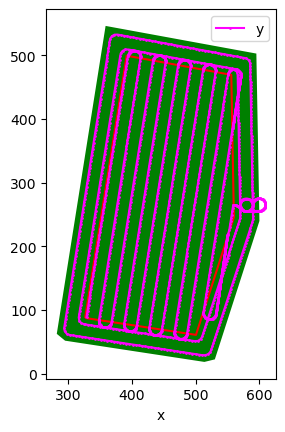

In [603]:

data_path ="./data/field_geometry/test_2.json"
include_obs = False
turning_rad = 10
distance = 20
headland_size = 40
interpolation_dist = 5

field, field_headlands, best_path,sp,swaths_clipped,base, total_path, bases = pathplanning(data_path,include_obs,turning_rad,distance,True,headland_size,interpolation_dist,1,False)

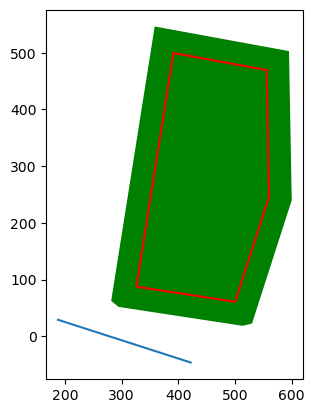

In [581]:
bases_df = gpd.GeoSeries(bases)
fig, ax = plt.subplots()
field.plot(ax = ax, color  = 'g')
field_headlands.boundary.plot(ax =ax, color = 'r')
ax.plot(*shapely.affinity.translate(bases_df[3],0,0).xy)

In [557]:
max(base.xy[0])


4251.171874159139

<Axes: >

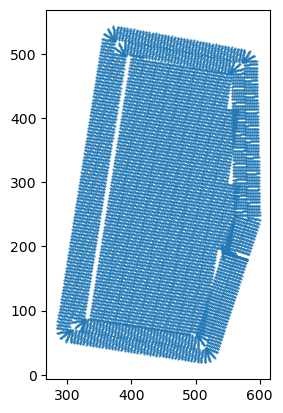

In [583]:
sp_df = gpd.GeoSeries(sp)
sp_df.plot(markersize = 0.2)
# plt.xlim([380,430])
# plt.ylim([100,200])
# plt.plot(*base.xy)


In [608]:
a = np.arange(0,20,1)
seed_count = len(a)
pointa = Point(sp_df.get_coordinates().iloc[0])
pointb = Point(sp_df.get_coordinates().iloc[1])
pointc = Point(sp_df.get_coordinates().iloc[seed_count+1])
pointd = Point(sp_df.get_coordinates().iloc[seed_count+2])


line = shapely.affinity.scale(LineString([pointa,pointc]),xfact = 1000,yfact = 1000)
line2 = shapely.affinity.scale(LineString([pointa,pointb]),xfact = 1000,yfact = 1000)
lines_hor = []
lines_ver = []
for i in range(-500,500):
    lines_ver.append(line.parallel_offset(1*i,'right'))
    lines_hor.append(line2.parallel_offset(interpolation_dist*i,'left'))
multline_hor = MultiLineString(lines_hor)
multline_ver = MultiLineString(lines_ver)
multline_df = gpd.GeoSeries(multline_hor)


In [609]:
from joblib import Parallel, delayed
imax = 1000
def process_hor(i):
    return sp.geoms[i].buffer(0.01).intersects(multline_hor)

def process_ver(i):
    return sp.geoms[i].buffer(0.01).intersects(multline_ver)
results_hor = Parallel(n_jobs=4)(delayed(process_hor)(i) for i in range(imax))
results_ver = Parallel(n_jobs=4)(delayed(process_ver)(i) for i in range(imax))
# print(results)  

In [610]:
results = [results_hor[i] and results_ver[i] for i in range(len(results_hor))]

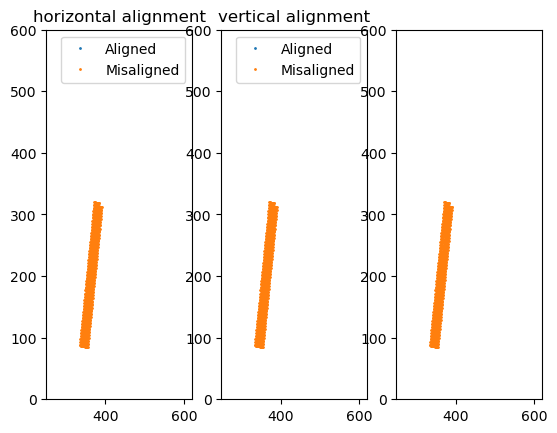

In [611]:
a = sp_df.get_coordinates().iloc[:imax]
a['on_grid_ver'] = results_ver
a['on_grid_hor'] = results_hor
a['on_grid'] = results
# a['on grid int'] = a['on grid'].astype(float)
fig, ax = plt.subplots(1,3)
for (v,c) in [(True,'b'),(False,'r')]:
    ax[0].plot(a.x[a.on_grid_hor == v],a.y[a.on_grid_hor == v],'o',markersize = 1)
ax[0].set_xlim([250,620])
ax[0].set_ylim([00,600])
ax[0].legend(['Aligned', 'Misaligned'])
for (v,c) in [(True,'b'),(False,'r')]:
    ax[1].plot(a.x[a.on_grid_ver == v],a.y[a.on_grid_ver == v],'o',markersize = 1)
ax[1].set_xlim([250,620])
ax[1].set_ylim([00,600])
ax[1].legend(['Aligned', 'Misaligned'])
for (v,c) in [(True,'b'),(False,'r')]:
    ax[2].plot(a.x[a.on_grid == v],a.y[a.on_grid == v],'o',markersize = 1)
ax[2].set_xlim([250,620])
ax[2].set_ylim([00,600])

ax[0].set_title('horizontal alignment')
ax[1].set_title('vertical alignment');

## GIFFFFFFSSSS


Below generates a gif of the path followed, yes i get distracted easily

In [165]:
total_path = pd.concat([best_path,headland_path])
len(total_path)

1794

In [142]:
sequence_len = 10
zeros = [0]*sequence_len
ones = [1]*sequence_len

command = []
while len(command)<= len(total_path):
    command+=zeros
    command+=ones
command = command[:len(total_path)]


1794

In [20]:
# total_path['planting'] = command
total_path.set_index(np.arange(len(total_path)))
# total_path

,x,y,command
0,551.505833,409.626269,1
1,546.563007,410.380240,1
2,541.620181,411.134211,1
3,536.677355,411.888183,1
4,531.734529,412.642154,1
...,...,...,...
1816,351.385275,53.412035,1
1817,346.442449,54.166006,1
1818,341.499623,54.919977,1
1819,336.556797,55.673949,1


In [164]:
total_path

,index,x,y,planting
0,0,383.696699,418.677162,0
1,1,385.229493,423.436421,0
2,2,386.762288,428.195679,0
3,3,388.295083,432.954938,0
4,4,389.827877,437.714196,0
...,...,...,...,...
1789,544,585.844593,330.177248,0
1790,545,586.027901,320.178928,1
1791,546,586.211210,310.180608,1
1792,547,586.394519,300.182289,1


IndexError: single positional indexer is out-of-bounds

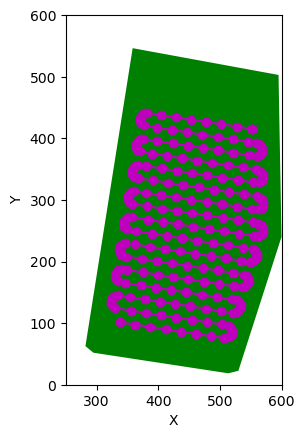

In [245]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
field.plot(ax = ax,color = 'g')

xdata, y = [], []

graph1, = ax.plot([], [], 'mo-')

# set up the plot
plt.xlim(250, 600)
plt.xlabel('X')
plt.ylim(0, 600)
plt.ylabel('Y')

# animation function
def animate(i):
    xdata.append(best_path.iloc[5*i]['x'])
    y.append(best_path.iloc[5*i]['y'])
    graph1.set_data(xdata, y)

    return (graph1,)

anim = animation.FuncAnimation(fig, animate,  frames=1000, interval=10, blit=True)
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=60)
anim.save('scatter.gif', writer=writer)
plt.show()

IndexError: single positional indexer is out-of-bounds

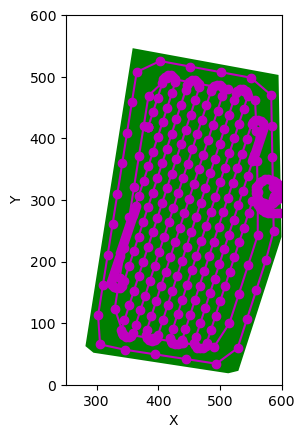

In [133]:
import matplotlib.animation as animation
df = total_path
fig, ax = plt.subplots()
field.plot(ax = ax,color = 'g')

xdata, y = [], []

graph1, = ax.plot([], [], 'mo-')

# set up the plot
plt.xlim(250, 600)
plt.xlabel('X')
plt.ylim(0, 600)
plt.ylabel('Y')

# animation function
def animate(i):
    xdata.append(df.iloc[5*i]['x'])
    y.append(df.iloc[5*i]['y'])
    graph1.set_data(xdata, y)

    return (graph1,)

anim = animation.FuncAnimation(fig, animate,  frames=1000, interval=10, blit=True)
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=60)
anim.save('headlands.gif', writer=writer)
plt.show()

In [ ]:
list(best_path.itertuples(index = False,name = None))

[(377.1540180066696, 505.1475248911465),
 (378.68681264571967, 509.9067832991865),
 (380.2196072847697, 514.6660417072264),
 (380.90076305156674, 516.7809997242528),
 (381.1592583664239, 517.7465809567711),
 (381.32006500791925, 518.7331447755106),
 (381.38157624924656, 519.730833760909),
 (381.3431774904155, 520.7296793344162),
 (381.2052523991312, 521.7197013612364),
 (380.969179077314, 522.6910078685353),
 (380.63731629155984, 523.633893882763),
 (380.2129799051249, 524.5389383985423),
 (379.713988125155, 525.405396056408),
 (379.27144630725587, 526.301679317328),
 (378.9205943753575, 527.2376653569023),
 (378.66493792598726, 528.2040021120193),
 (378.5070313938784, 529.1910342652506),
 (378.4484525289028, 530.1888997175902),
 (378.4897866317158, 531.187628127289),
 (378.6306207056252, 532.177240530213),
 (378.86954758311805, 533.1478490463544),
 (379.20417998581325, 534.0897556762607),
 (379.6311743773578, 534.9935492002385),
 (380.14626437093705, 535.8501992121509),
 (380.74430335